In [ ]:
! pip install -qq  langchain-openai langchain langgraph

In [ ]:
import sqlite3

In [ ]:
conn = sqlite3.connect("store.db", check_same_thread = False)

In [ ]:
#create users table
conn.execute('''
CREATE TABLE IF NOT EXISTS users (
    id INTEGER PRIMARY KEY,
    name TEXT,
    email TEXT,
    signup_date DATE
)
''')

# Create orders table
conn.execute('''
CREATE TABLE IF NOT EXISTS orders (
    id INTEGER PRIMARY KEY,
    user_id INTEGER,
    amount REAL,
    status TEXT,
    order_date DATE,
    FOREIGN KEY(user_id) REFERENCES users(id)
)
''')

# Insert users
conn.execute("INSERT INTO users VALUES (1, 'Alice', 'alice@example.com', '2024-01-10')")
conn.execute("INSERT INTO users VALUES (2, 'Bob', 'bob@example.com', '2024-03-15')")
conn.execute("INSERT INTO users VALUES (3, 'Charlie', 'charlie@example.com', '2024-03-22')")
conn.execute("INSERT INTO users VALUES (4, 'Diana', 'diana@example.com', '2024-04-05')")
conn.execute("INSERT INTO users VALUES (5, 'Eve', 'eve@example.com', '2024-04-25')")
conn.execute("INSERT INTO users VALUES (6, 'Frank', 'frank@example.com', '2024-05-15')")
conn.execute("INSERT INTO users VALUES (7, 'Grace', 'grace@example.com', '2024-05-18')")
conn.execute("INSERT INTO users VALUES (8, 'Henry', 'henry@example.com', '2024-05-20')")
conn.execute("INSERT INTO users VALUES (9, 'Ivy', 'ivy@example.com', '2024-06-01')")
conn.execute("INSERT INTO users VALUES (10, 'Jack', 'jack@example.com', '2024-06-05')")
conn.execute("INSERT INTO users VALUES (11, 'Kiran', 'kiran@example.com', '2024-06-03')")
conn.execute("INSERT INTO users VALUES (12, 'Lata', 'lata@example.com', '2024-06-04')")
conn.execute("INSERT INTO users VALUES (13, 'Manoj', 'manoj@example.com', '2024-06-06')")

# Insert orders
conn.execute("INSERT INTO orders VALUES (1, 1, 250.00, 'completed', '2024-03-10')")
conn.execute("INSERT INTO orders VALUES (2, 2, 100.00, 'pending', '2024-03-16')")
conn.execute("INSERT INTO orders VALUES (3, 3, 320.00, 'completed', '2024-03-24')")
conn.execute("INSERT INTO orders VALUES (4, 4, 180.00, 'completed', '2024-05-01')")
conn.execute("INSERT INTO orders VALUES (5, 5, 210.00, 'completed', '2024-05-02')")
conn.execute("INSERT INTO orders VALUES (6, 1, 180.00, 'completed', '2024-03-18')")
conn.execute("INSERT INTO orders VALUES (7, 2, 120.00, 'completed', '2024-03-20')")
conn.execute("INSERT INTO orders VALUES (8, 1, 300.00, 'completed', '2024-04-01')")
conn.execute("INSERT INTO orders VALUES (9, 3, 80.00, 'cancelled', '2024-04-10')")
conn.execute("INSERT INTO orders VALUES (10, 4, 250.00, 'pending', '2024-05-05')")
conn.execute("INSERT INTO orders VALUES (11, 6, 400.00, 'completed', '2024-05-20')")
conn.execute("INSERT INTO orders VALUES (12, 7, 320.00, 'completed', '2024-05-22')")
conn.execute("INSERT INTO orders VALUES (13, 8, 150.00, 'pending', '2024-05-25')")
conn.execute("INSERT INTO orders VALUES (14, 9, 220.00, 'completed', '2024-06-02')")
conn.execute("INSERT INTO orders VALUES (15, 10, 500.00, 'completed', '2024-06-06')")


conn.commit()

# ***User gives Query -> LLM -> Get Schema -> llm (generate response) -> LLM (presents results)***

In [ ]:
from langchain.agents import tool

@tool
def get_schema() -> str:
  """
  Returns Tables Schemas from the SQLite Tables
  """
  schema = ""
  for table in ["users", "orders"]:
    rows = conn.execute(f"PRAGMA table_info({table})").fetchall()
    cols = ",".join([f"{r[1]} {r[2]}" for r in rows])
    schema += f"{table}({cols})\n"
  print(f"Schema : {schema.strip()}")
  return schema.strip()

In [ ]:
@tool
def execute_sql(query: str) -> str:
  """
  Executes the SQL query and returns the output.
  """
  try:
    res = conn.execute(query).fetchall()
    return str(res)
  except Exception as e:
    print(f"Exception : {e} occurred while execuring the Query : {query}")

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from langchain_openai import ChatOpenAI
from langchain.schema import AIMessage
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_PROJECT"] = ""
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
from typing import Annotated, TypedDict
llm = ChatOpenAI(model = "gpt-4o-mini")

tools = [get_schema, execute_sql]
llm_with_tools = llm.bind_tools(tools)


class AgentState(TypedDict):
  messages :Annotated[list[AnyMessage], add_messages]

In [ ]:
def agent(state: AgentState) -> AgentState:
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

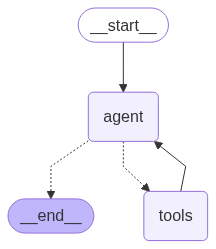

In [ ]:
builder = StateGraph(AgentState)



builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(tools))

builder.set_entry_point("agent")
builder.add_conditional_edges("agent", tools_condition)
builder.add_edge("tools", "agent")

app = builder.compile()

app

In [ ]:
def fetch_response(query : str) -> str:
  input = {"messages" : [{"role":"user", "content": query}]}
  final_message = None
  for output in app.stream(input):
    for key, value in output.items():
      print(f" Node : {key}")
      print(value["messages"])
      final_message = value["messages"]

  if final_message:
    print(f"Final Response for query {query}: {final_message[0].content}")


In [ ]:
query = "List the users who have completed the orders in 2024 March?"
fetch_response(query)

 Node : agent
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uElB02ZbP6oAc153HFD79IOq', 'function': {'arguments': '{}', 'name': 'get_schema'}, 'type': 'function'}, {'id': 'call_Wcf3Rh3twgH5aHxHw2QnaYTB', 'function': {'arguments': '{"query": "SELECT * FROM orders WHERE status = \'completed\' AND date BETWEEN \'2024-03-01\' AND \'2024-03-31\';"}', 'name': 'execute_sql'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 77, 'total_tokens': 147, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CBtNn4sl7Girch7ehmuh5uLIWaCjh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cea5e001-1b85-45cd-bdce-4394ec6f092d-0', too

In [ ]:
query = "List all the users along with the sum of their purchases in decreasing order of total amount. If the user has no orders then their total amount is zero."
fetch_response(query)

 Node : agent
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RiZt816yILvMWdK2rbJEcO3k', 'function': {'arguments': '{}', 'name': 'get_schema'}, 'type': 'function'}, {'id': 'call_D9QcfU9HqhWtZJCwitNuVOsN', 'function': {'arguments': '{"query": "SELECT u.id, u.name, COALESCE(SUM(o.amount), 0) as total_amount \\nFROM users u \\nLEFT JOIN orders o ON u.id = o.user_id \\nGROUP BY u.id, u.name \\nORDER BY total_amount DESC;"}', 'name': 'execute_sql'}, 'type': 'function'}, {'id': 'call_xXgfotkZaWaIIxhNB3RaFuhj', 'function': {'arguments': '{"query": "SELECT * FROM users;"}', 'name': 'execute_sql'}, 'type': 'function'}, {'id': 'call_aCStYAgk4FkC4XdWmdqOh27L', 'function': {'arguments': '{"query": "SELECT * FROM orders;"}', 'name': 'execute_sql'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 132, 'prompt_tokens': 94, 'total_tokens': 226, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reason